In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from IPython.display import clear_output
import umap
from random import randint

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsTransformer

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-16 23:32:16.268252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-16 23:32:16.268322: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-16 23:32:16.268388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-16 23:32:16.276728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This T

In [2]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [19]:
data["tile_features"] = np.array(data["tiles"]).reshape((202, 16 ,9408))

In [44]:
x = data["tile_features"].reshape((3232 ,9408))
tile_imgs = data["tiles"].reshape((3232 ,56,56,3))

In [35]:
data["tile_images"] = tile_imgs

In [45]:
pca = PCA(n_components=100, random_state=22)
pca.fit(x)
pca_out = pca.transform(x)
data["tile_factor"]=pca_out

In [89]:
x = data["tile_features"].reshape((3232 ,9408))
kmeans = KMeans(n_clusters=12, random_state=69)
kmeans.fit(x)

KMeans(n_clusters=12, random_state=69)

In [90]:
kmeans.cluster_centers_.shape

(12, 9408)

In [ ]:
data["tile_cluster"] = kmeans.labels_
data["tile_centroids"] = kmeans.cluster_centers_

In [92]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

array([ 240, 1824,  152,   93,   80,   60,  231,  115,  163,   66,   93,
        115])

In [ ]:
data["all_tiles"] = data["tiles"].reshape(3232,56,56,3)

In [3]:
transformer = KNeighborsTransformer(n_neighbors=5, mode='connectivity')
graph = transformer.fit_transform(data["all_tiles"].reshape(3232,9408)).toarray()

In [4]:
def adjacency_to_coo(adj_matrix):
    rows, cols = np.where(adj_matrix != 0)
    non_diagonal_mask = rows != cols
    
    filtered_rows = rows[non_diagonal_mask]
    filtered_cols = cols[non_diagonal_mask]
    
    coo_list = np.stack([filtered_rows, filtered_cols], axis=1)
    return coo_list

graph = adjacency_to_coo(graph)

In [5]:
data["tile_knn_edge_index"] = graph

In [39]:
root_dir = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/test_clusters"

for i in range(len(data["tile_cluster"])):
    cluster_id = data["tile_cluster"][i]
    image_data = data["tile_images"][i]
    
    if image_data is not None:
        try:
            image = Image.fromarray(image_data)
        except TypeError:
            image = image_data
        
        cluster_dir = os.path.join(root_dir, str(cluster_id))

        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)

        save_path = os.path.join(cluster_dir, f"image_{i}.jpeg")
        image.save(save_path, "JPEG")

In [93]:
print(data["cluster"].shape)
print(data["factor"].shape)

(202,)
(202, 100)


In [38]:
n=-1

In [10]:
data["tile_knn_edge_index"].shape

(13243, 2)

In [8]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed.pk1', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#BACKUP
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed_backup.pk1', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) # Last updated - Data Centroids added

In [2]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [25]:
temp_path = "C://Austin//Projects//MS_Thesis_Data//temp"

for i in range(len(data["cluster"])):
    clust_path = os.path.join(temp_path, str(data["cluster"][i]))
    if not os.path.exists(clust_path):
        os.mkdir(clust_path)
    else:
        im = Image.fromarray(data["image"][i])
        im.save(os.path.join(clust_path, data["name"][i]))
    


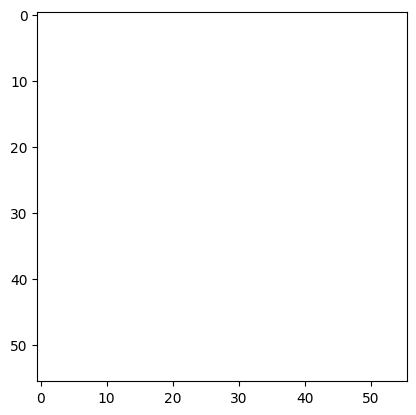

In [48]:
plt.imshow(data["tiles"][0][15].reshape([56,56,3]))

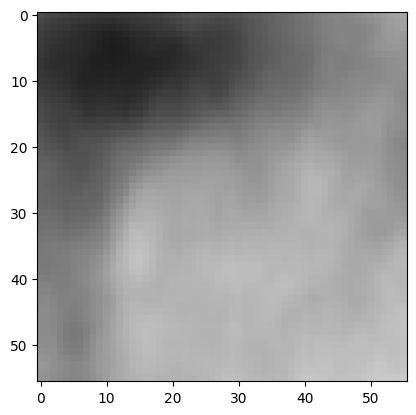

In [32]:
plt.imshow(np.array(data["tile_centroids"][11]/255).reshape([56,56,3]))

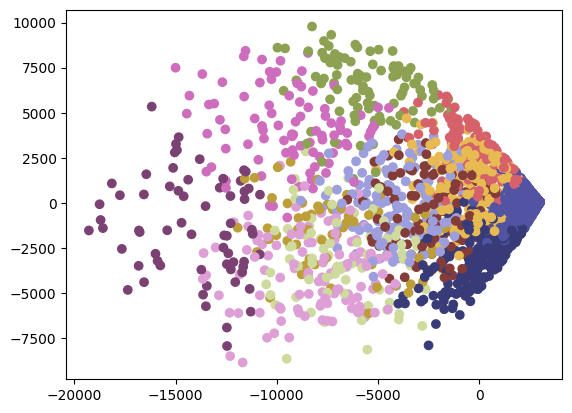

In [3]:
i = 0
xx = [k[i] for k in data["tile_factor"]]
y = [k[i+1] for k in data["tile_factor"]]

plt.scatter(xx,y,c=data["tile_cluster"], cmap="tab20b")
plt.show()

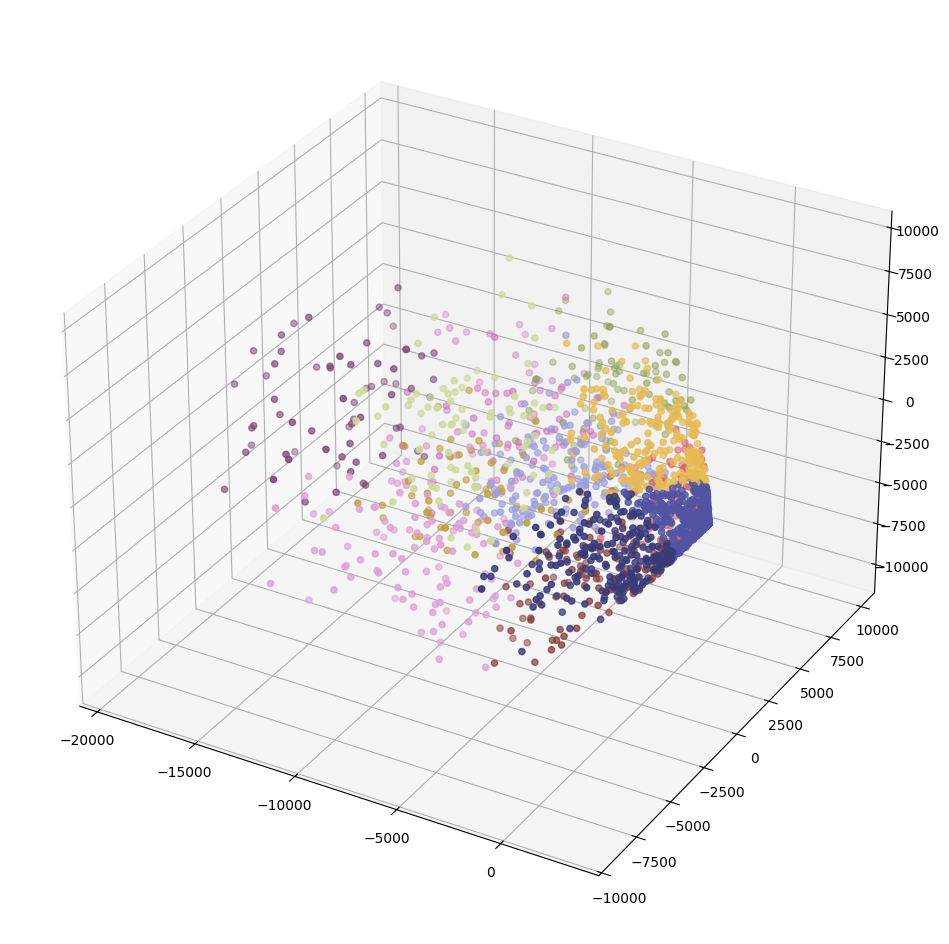

In [4]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

z = [k[i+2] for k in data["tile_factor"]]

ax.scatter(xx, y, z, c=data["tile_cluster"], cmap="tab20b")
plt.show()

In [107]:
reducer = umap.UMAP(
    n_components=3, n_neighbors=100, random_state=69, transform_seed=42, verbose=False
)

In [108]:
x = data["tile_features"].reshape((3232 ,9408))
reducer.fit(x)

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_components=3, n_jobs=1, n_neighbors=100, random_state=69, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
embedding = reducer.transform(x)
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(3232, 3)

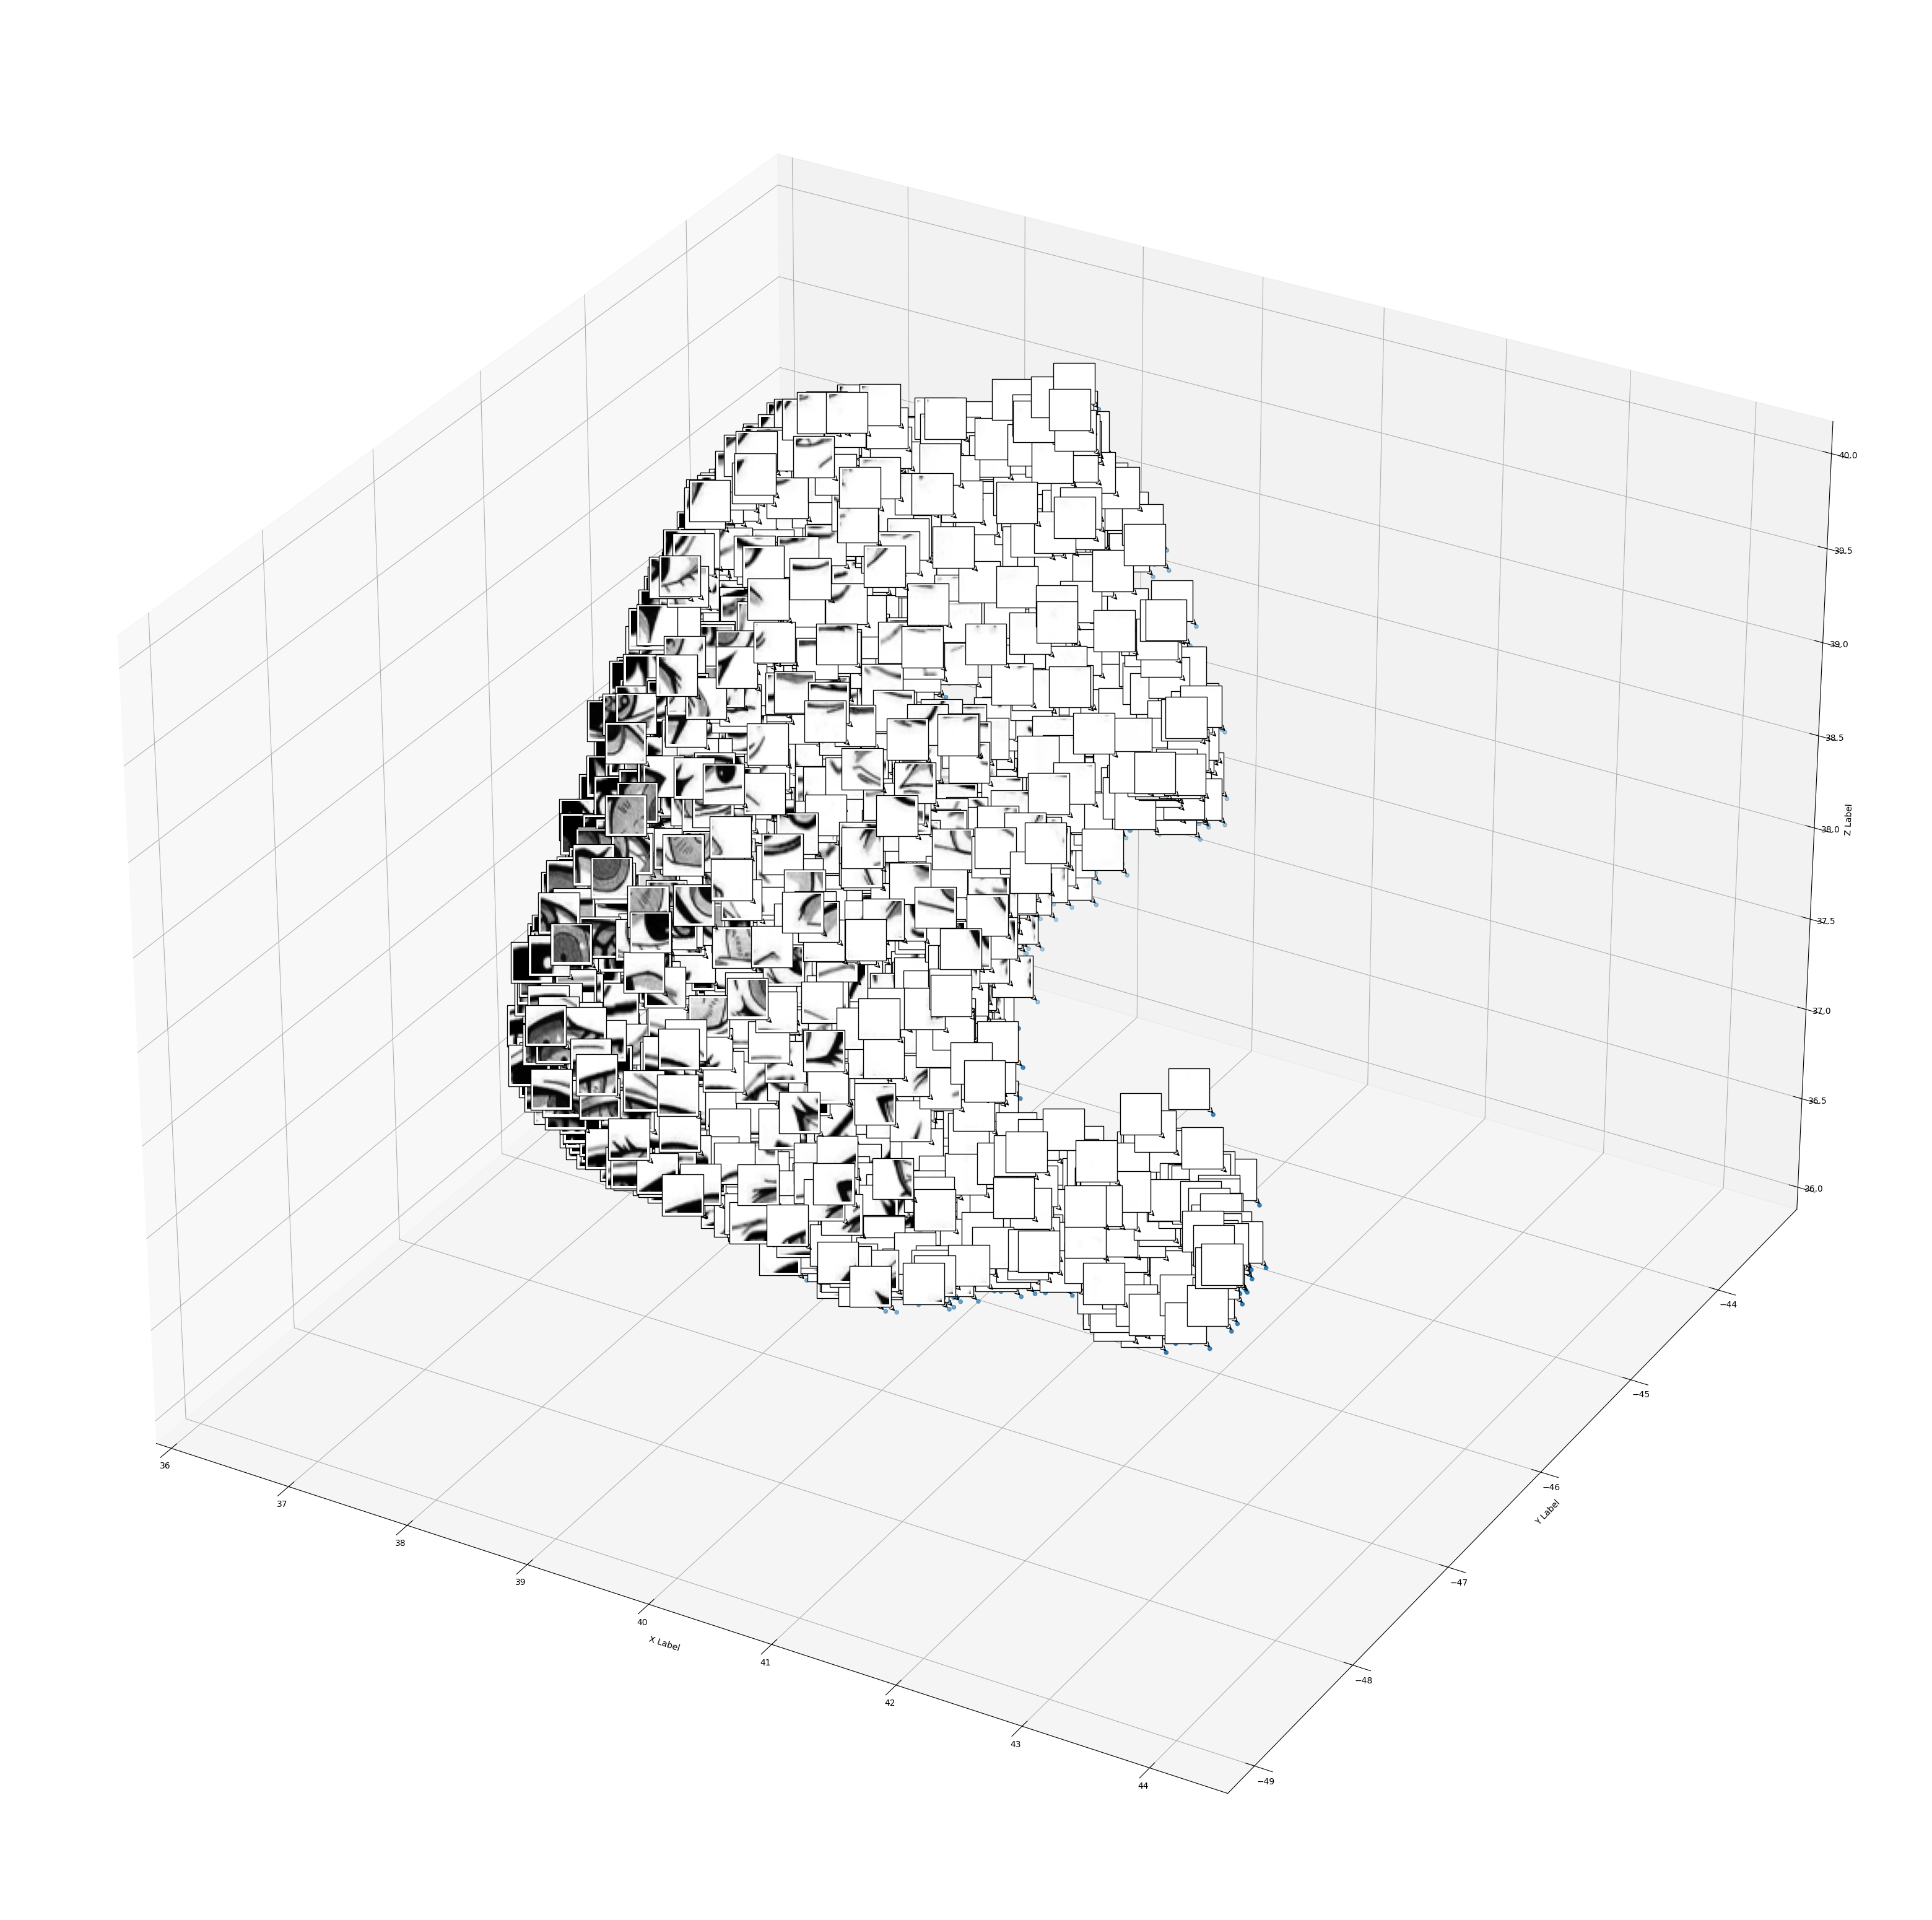

In [109]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np

xs = embedding[:, 0]
ys = embedding[:, 1]
zs = embedding[:, 2]

fig = plt.figure(figsize=(40,40))
ax = fig.add_subplot(111, projection=Axes3D.name)

ax.scatter(xs, ys, zs, marker="o")

# Create a dummy axes to place annotations to
ax2 = fig.add_subplot(111,frame_on=False) 
ax2.axis("off")
ax2.axis([0,1,0,1])


def proj(X, ax1, ax2):
    """ From a 3D point in axes ax1, 
        calculate position in 2D in ax2 """
    x,y,z = X
    x2, y2, _ = proj3d.proj_transform(x,y,z, ax1.get_proj())
    return ax2.transData.inverted().transform(ax1.transData.transform((x2, y2)))

def image(ax,arr,xy):
    """ Place an image (arr) as annotation at position xy """
    im = offsetbox.OffsetImage(arr, zoom=2)
    im.image.axes = ax
    ab = offsetbox.AnnotationBbox(im, xy, xybox=(-30., 30.),
                        xycoords='data', boxcoords="offset points",
                        pad=0.3, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)


i=-1
for s in zip(xs,ys,zs):
    i=i+1
    x,y = proj(s, ax, ax2)
    image(ax2,cv2.resize(tile_imgs[i], (21,21)),[x,y])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

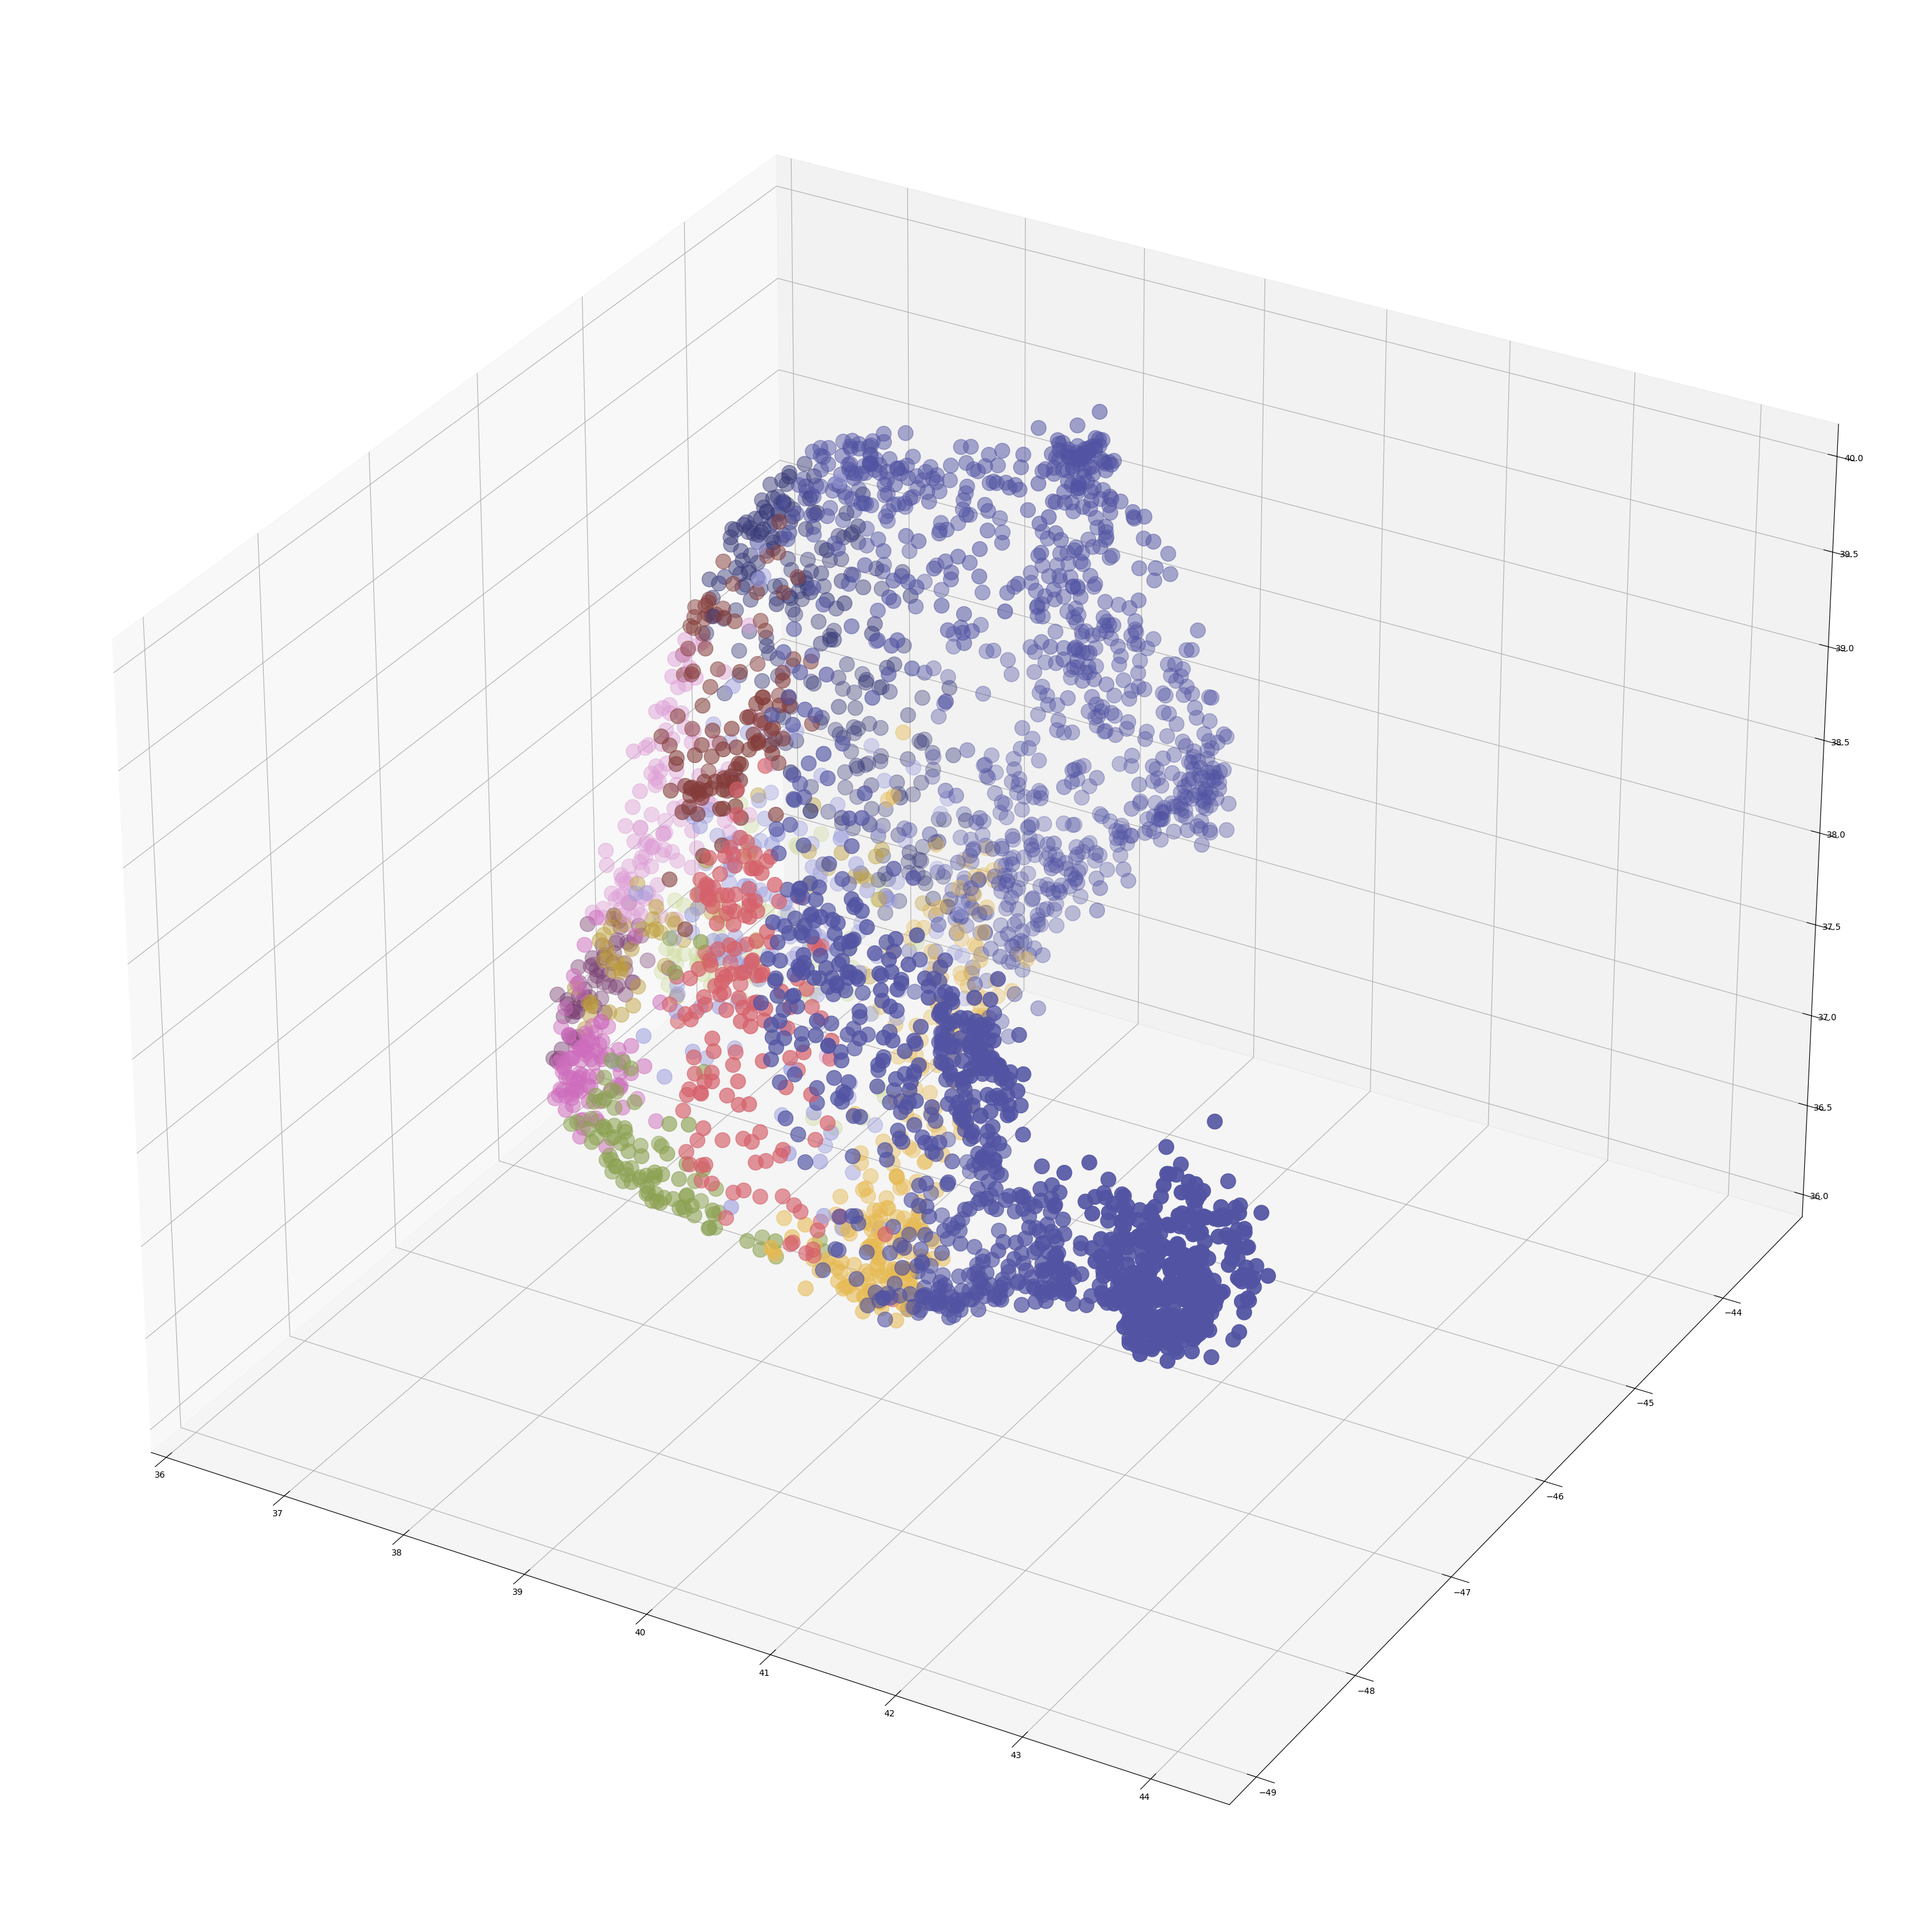

In [110]:
from matplotlib.offsetbox import AnnotationBbox

fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(projection='3d')

ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c = data["tile_cluster"], s=300, cmap="tab20b")

plt.show()

In [ ]:
data["umap_reducer"]

In [34]:
data["umap_reducer"] = embedding

In [35]:
data.keys()

dict_keys(['name', 'image', 'features', 'factor', 'cluster', 'umap_reducer'])